# Topological optimization of the ICLR acronym into 4 clusters

In this notebook, we show how a topological loss can be use to optimize a data set for four clusters.

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import numpy as np
import pandas as pd

# Random sampling
import random

# Functions for deep learning (Pytorch)
import torch
from torch import nn

# Pytorch compatible topology layer
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Load and view data

We load and view the data as follows.

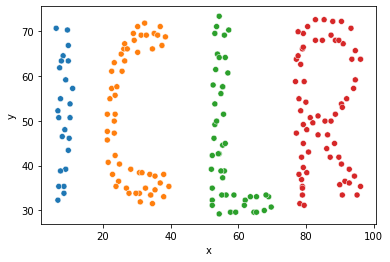

In [2]:
# Load the data
data = pd.read_csv(os.path.join("Data", "ICLR.csv"), delimiter=" ")

# Plot the data
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x", y="y", hue="group", ax=ax)
ax.legend().remove()
plt.show()

## Apply topological optimization to the embedding

We now show how we can use topological optimization to encourage the model underlying the data to become connected. As a topological loss, we will use the persistence of the fourth most prominent gap.

In [3]:
# Define topological loss
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=0) # alpha complex layer
Component4Persistence = DiagramLoss(dim=0, i=4, j=4, g=g) # compute persistence of fourth most prominent gap

# Construct topological loss function
def top_loss(output):
    dgminfo = TopLayer(output)            
    loss = - Component4Persistence(dgminfo)
    
    return loss

We can now conduct the topological optimization as follows.

[epoch 1] [topological loss: -8.496401]
[epoch 50] [topological loss: -13.443504]
[epoch 100] [topological loss: -16.110245]
[epoch 150] [topological loss: -18.056824]
[epoch 200] [topological loss: -19.873667]
[epoch 250] [topological loss: -21.365299]
[epoch 300] [topological loss: -22.824858]
[epoch 350] [topological loss: -23.973787]
[epoch 400] [topological loss: -24.931015]
[epoch 450] [topological loss: -25.632105]
[epoch 500] [topological loss: -26.259472]


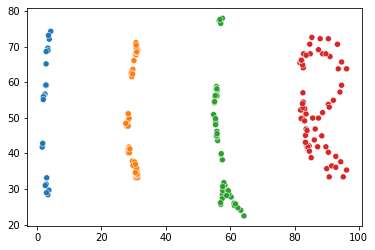

In [4]:
# Learning hyperparameters
num_epochs = 500
learning_rate = 1e-1

# Conduct topological optimization
Y = torch.autograd.Variable(torch.tensor(np.array(data.loc[:,["x","y"]])).type(torch.float), requires_grad=True)
optimizer = torch.optim.Adam([Y], lr=learning_rate)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = top_loss(Y)
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch + 1) % (int(num_epochs / 10)) == 0:
        print ("[epoch %d] [topological loss: %f]" % (epoch + 1, loss.item()))
        
Y = Y.detach().numpy().copy()

# View topologically optimized embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=data.loc[:,"group"], ax=ax)
ax.get_legend().remove()
plt.show()

We see that ordinary topological optimization resulted in at least four more prominently separated clusters, but points from the same letter in the ICLR acronym are also fragmented into different clusters. Here again, we may use a sampling strategy to both improve the computational efficiency and efectiveness of topological optimization, as we see below.

[epoch 1] [topological loss: -14.186261]
[epoch 50] [topological loss: -15.832344]
[epoch 100] [topological loss: -13.548508]
[epoch 150] [topological loss: -16.434792]
[epoch 200] [topological loss: -18.786116]
[epoch 250] [topological loss: -18.687740]
[epoch 300] [topological loss: -20.456610]
[epoch 350] [topological loss: -22.089548]
[epoch 400] [topological loss: -23.532574]
[epoch 450] [topological loss: -24.267517]
[epoch 500] [topological loss: -25.250372]


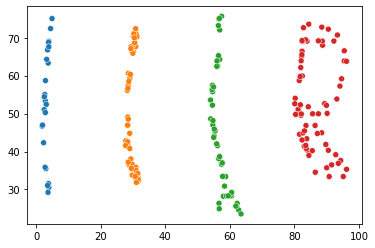

In [5]:
# Learning hyperparameters
top_frac = 0.25
num_epochs = 500
learning_rate = 1e-1

# Conduct topologically optimization
Y = torch.autograd.Variable(torch.tensor(np.array(data.loc[:,["x","y"]])).type(torch.float), requires_grad=True)
optimizer = torch.optim.Adam([Y], lr=learning_rate)

random.seed(42)
for epoch in range(num_epochs):
    optimizer.zero_grad()
    I = random.sample(range(Y.shape[0]), int(Y.shape[0] * top_frac))
    loss = top_loss(Y[I,:])
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch + 1) % (int(num_epochs / 10)) == 0:
        print ("[epoch %d] [topological loss: %f]" % (epoch + 1, loss.item()))
        
Y = Y.detach().numpy().copy()

# View topologically optimized embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=data.loc[:,"group"], ax=ax)
ax.legend().remove()
plt.show()

Note that the sampling strategy is not a guarantee that the points in the four different clusters will remain clustered together. Indeed, the topological loss function does not care whether neighboring points remain close to each other, as long as it reaches **at least** four clusters. Hence, we can also see that fragmentation starts to occur in the current case, which will likely worsen for further epochs. As seen in the main paper, this can be effectively resolved through topological regularization.  